# Genetic Algorithm for SNN

In [1]:
import numpy as np
import random
from random import randint
import operator
from array import *
import math
import time
import itertools
import sys 
import os

In [2]:
import subprocess
import re

def run_SNN(N_ev, tau_m, tau_s, tau_plus, tau_minus, a_plus, a_minus, CFI0, CF01, CFI1, alpha, TH0, TH1):
    try:
        command = f'../SNNT13.out --N_ev {N_ev} --tau_m {tau_m} --tau_s {tau_s} --tau_plus {tau_plus} --tau_minus {tau_minus} --a_plus {a_plus} --a_minus {a_minus} --CFI0 {CFI0} --CF01 {CF01} --CFI1 {CFI1} --alpha {alpha} --TH0 {TH0} --TH1 {TH1}'
        result = subprocess.run(command, shell=True, capture_output=True, text=True)
        relevant_lines = [line.strip() for line in result.stdout.split('\n') if 'Average efficiency' in line or 'Average fake rate' in line or 'L1 selectivity' in line]
        values = [float(re.search(r'\d+\.\d+', line).group()) if re.search(r'\d+\.\d+', line) else 0 for line in relevant_lines]
        return values
    
    except Exception as e:
        print(f"Errore durante l'esecuzione di SNN: {e}")
        return None

output_values = run_SNN(
    N_ev=300, tau_m=1e-9/2, tau_s=0.25e-9/2, tau_plus=1.68e-9/2, tau_minus=3.37e-9/2, a_plus=0.00003125/10, a_minus=0.001, CFI0=1, CF01=1, CFI1=1, alpha=0.5, TH0=0.45, TH1=0.45,
)

if output_values:
    print(f'Average efficiency: {output_values[0]}')
    print(f'Average fake rate: {output_values[1]}')
    print(f'L1 selectivity: {output_values[2]}')

Average efficiency: 0.527778
Average fake rate: 0
L1 selectivity: 0.565538


In [3]:
!../SNNT13.out --N_ev 300 --tau_m 1e-9/2 --tau_s 0.25e-9/2 --tau_plus 1.68e-9/2 --tau_minus 3.37e-9/2 --a_plus 0.00003125/10 --a_minus 0.001 --CFI0 1 --CF01 1 --CFI1 1 --alpha 0.5 --TH0 0.45 --TH1 0.45

  Too few events per epoch. Set to 10000


                                 ------------------------------------

                                    S   N   N      T r a c k i n g

                                 ------------------------------------




         ------------------------------------------------------------------------------------    
         Unsupervised search for tracks in 8-layer strip detector with spiking neural network    
                                                                             T.Dorigo, 3/2023    
         ------------------------------------------------------------------------------------    

         Run parameters: 
         -----------------------------------
                       L0 neurons: 6
                       L1 neurons: 6
            Connected L0-L1 frac.: 1
            Connected IN-L0 frac.: 1
            Connected IN-L1 frac.: 1
                    Track classes: 6
                     Total events: 300
               Opti

## Fitness Selectivity

In [4]:
# #fitness function
# def fitness(N_ev, tau_m, tau_s, tau_plus, tau_minus, a_minus, a_plus, CFI0, CF01, CFI1, alpha, TH0, TH1):

#     output_values = run_SNN(N_ev, tau_m, tau_s, tau_plus, tau_minus, a_minus, a_plus, CFI0, CF01, CFI1, alpha, TH0, TH1)
#     #if selectivity is 1 than the fitness is 0
#     if output_values[2] == 1:
#         return 0
#     else:
#         print('Selectivity: ', output_values[2])
#         return -(output_values[2])
# fitness(300, 1e-9/2, 0.25e-9/2, 1.68e-9/2, 3.37e-9/2, 0.001, 0.00003125/10, 1, 1, 1, 0.5, 0.45, 0.45)


## Fitness Efficiency - Fake

In [5]:
#fitness function
def fitness(N_ev, tau_m, tau_s, tau_plus, tau_minus, a_minus, a_plus, CFI0, CF01, CFI1, alpha, TH0, TH1):

    output_values = run_SNN(N_ev, tau_m, tau_s, tau_plus, tau_minus, a_minus, a_plus, CFI0, CF01, CFI1, alpha, TH0, TH1)
    if output_values[0] - output_values[1] < 0:
        return 0
    
    return -(output_values[0] - output_values[1])


fitness(300, 1e-9/2, 0.25e-9/2, 1.68e-9/2, 3.37e-9/2, 0.001, 0.00003125/10, 1, 1, 1, 0.5, 0.45, 0.45)


0

## Selecting the best numbers of starting parents and selcelted childeens


In [6]:
#delete the values.csv
if os.path.exists('values.csv'):
    os.remove('values.csv')

#create the values.csv and write the header
with open('values.csv', 'w') as file:
    file.write('tau_m,tau_s,tau_plus,tau_minus,a_minus,a_plus,CFI0,CF01,CFI1,alpha,TH0,TH1,fitness\n')

In [7]:
# random.seed(random.random())


num_parameters = 12

# Initialize parameters
population_size = 4
MAX_population_size = 20

num_childs = 4
pc = 0.6  # Probability of crossover
pm = 0.1  # Probability of mutation

N_ev = 300 #>100

In [8]:
tau_m, tau_m_MAX, tau_m_MIN = 1e-9, 1e-9*4, 1e-9/4
tau_s, tau_s_MAX, tau_s_MIN = 0.25e-9, 0.25e-9*5, 0.25e-9/2/5
tau_plus, tau_plus_MAX, tau_plus_MIN = 1.68e-9, 1.68e-9*4, 1.68e-9/4
tau_minus, tau_minus_MAX, tau_minus_MIN = 3.37e-9, 3.37e-9*3, 3.37e-9/3
a_minus, a_minus_MAX, a_minus_MIN = 0.00002656, 0.00002656*10, 0.00002656/10
a_plus, a_plus_MAX, a_plus_MIN = 0.00003125, 0.00003125*10, 0.00003125/10
CFI0, CFI0_MAX, CFI0_MIN = 0.8, 1, 0.1
CF01, CF01_MAX, CF01_MIN = 0.8, 1, 0.1
CFI1, CFI1_MAX, CFI1_MIN = 0.8, 1, 0.1
alpha, alpha_MAX, alpha_MIN = 0.5, 1, 0.1
TH0, TH0_MAX, TH0_MIN = 0.45, 0.45*2, 0.45/2
TH1, TH1_MAX, TH1_MIN = 0.45, 0.45*2, 0.45/2

In [9]:
# Mapping functions
def encode_and_scale(real_value, min_value, max_value, num_bits):
    scaled_value = int((real_value - min_value) / (max_value - min_value) * (2**num_bits - 1))
    binary_representation = bin(scaled_value)[2:].zfill(num_bits)
    return binary_representation

def decode_and_rescale(encoded_value, min_value, max_value, num_bits):
    scaled_value = int(encoded_value, 2)
    real_value = min_value + scaled_value / (2**num_bits - 1) * (max_value - min_value)
    return real_value


# Initialize the population
def InitPopulation():
    generations = {}
    for i in range(population_size):
        random_tau_m = random.uniform(tau_m_MIN, tau_m_MAX)
        random_tau_s = random.uniform(tau_s_MIN, tau_s_MAX)
        random_tau_plus = random.uniform(tau_plus_MIN, tau_plus_MAX)
        random_tau_minus = random.uniform(tau_minus_MIN, tau_minus_MAX)
        random_a_minus = random.uniform(a_minus_MIN, a_minus_MAX)
        random_a_plus = random.uniform(a_plus_MIN, a_plus_MAX)
        random_CFI0 = random.uniform(CFI0_MIN, CFI0_MAX)
        random_CF01 = random.uniform(CF01_MIN, CF01_MAX)
        random_CFI1 = random.uniform(CFI1_MIN, CFI1_MAX)
        random_alpha = random.uniform(alpha_MIN, alpha_MAX)
        random_TH0 = random.uniform(TH0_MIN, TH0_MAX)
        random_TH1 = random.uniform(TH1_MIN, TH1_MAX)


        fit = fitness(N_ev, random_tau_m, random_tau_s, random_tau_plus, random_tau_minus, random_a_minus, random_a_plus, random_CFI0, random_CF01, random_CFI1, random_alpha, random_TH0, random_TH1)
        tau_m_bin = encode_and_scale(random_tau_m, tau_m_MIN, tau_m_MAX, 10)
        tau_s_bin = encode_and_scale(random_tau_s, tau_s_MIN, tau_s_MAX, 10)
        tau_plus_bin = encode_and_scale(random_tau_plus, tau_plus_MIN, tau_plus_MAX, 10)
        tau_minus_bin = encode_and_scale(random_tau_minus, tau_minus_MIN, tau_minus_MAX, 10)
        a_minus_bin = encode_and_scale(random_a_minus, a_minus_MIN, a_minus_MAX, 10)
        a_plus_bin = encode_and_scale(random_a_plus, a_plus_MIN, a_plus_MAX, 10)
        CFI0_bin = encode_and_scale(random_CFI0, CFI0_MIN, CFI0_MAX, 10)
        CF01_bin = encode_and_scale(random_CF01, CF01_MIN, CF01_MAX, 10)
        CFI1_bin = encode_and_scale(random_CFI1, CFI1_MIN, CFI1_MAX, 10)
        alpha_bin = encode_and_scale(random_alpha, alpha_MIN, alpha_MAX, 10)
        TH0_bin = encode_and_scale(random_TH0, TH0_MIN, TH0_MAX, 10)
        TH1_bin = encode_and_scale(random_TH1, TH1_MIN, TH1_MAX, 10)


        dna = tau_m_bin + tau_s_bin + tau_plus_bin + tau_minus_bin + a_minus_bin + a_plus_bin + CFI0_bin + CF01_bin + CFI1_bin + alpha_bin + TH0_bin + TH1_bin
        generations[i] = {"dna": dna, "fitness": fit}
    return generations


def roulette_wheel(generationDictN):
    total_fitness = sum(individual["fitness"] for individual in generationDictN.values())
    if total_fitness == 0:
        return generationDictN
    selection_probabilities = {key: individual["fitness"] / total_fitness for key, individual in generationDictN.items()}
    
    cumulative_probabilities = {}
    cumulative_prob = 0
    for key, prob in selection_probabilities.items():
        cumulative_prob += prob
        cumulative_probabilities[key] = cumulative_prob
    
    new_generation = {}
    for _ in range(len(generationDictN)):
        rand_num = random.random()
        selected_key = next(key for key, prob in cumulative_probabilities.items() if prob >= rand_num)
        new_generation[_] = generationDictN[selected_key]
    
    return new_generation


# Crossover function
def CrossOver(SelectedNumbersDict):
    NewGenFromSelected = {}

    for i in range(0, len(SelectedNumbersDict) - 1, 2):  # Adjusted loop condition
        randnum = random.random()
        cod1 = SelectedNumbersDict[i]["dna"]
        cod2 = SelectedNumbersDict[i + 1]["dna"]


        # Add parents to the new generation if they don't pass the probability
        if randnum > pc:
            NewGenFromSelected[i] = {"dna": cod1}
            NewGenFromSelected[i + 1] = {"dna": cod2}
        else:
            # Add children to the new generation if they pass the probability
            num1 = [cod1[i:i+10] for i in range(0, len(cod1), 10)]
            num2 = [cod2[i:i+10] for i in range(0, len(cod2), 10)]

            a = [1, 2]
            comb = list(itertools.product(a, repeat=num_parameters))
            
            #shuffle randomly the combinations
            random.shuffle(comb)

            sel_comb = random.sample(comb, num_childs)

            child = ["" for _ in range(num_childs)]
            for c in range(num_childs):
                child[c] = ""
                for k in range(num_parameters):
                    if sel_comb[c][k] == 1:
                        child[c] += num2[k]
                    elif sel_comb[c][k] == 2:
                        child[c] += num1[k]
            # Add the children to the new generation
            for c in range(2):
                NewGenFromSelected[len(NewGenFromSelected)] = {"dna": child[c]}

    # never true, but I don't want to risk the machines
    if len(NewGenFromSelected) > MAX_population_size:
        NewGenFromSelected = dict(random.sample(NewGenFromSelected.items(), MAX_population_size))

    return NewGenFromSelected


# Mutation function
def Mutation(individual):
    encoded_value = individual["dna"]
    mutated_encoded_value = ''.join(
        '0' if bit == '1' and random.random() < pm else '1' if bit == '0' and random.random() < pm else bit
        for bit in encoded_value
    )
    individual["dna"] = mutated_encoded_value
    return individual

# Decode the fitness and calculate it for each new generation
def DecodeAndCalFitness(SelectedNumbersDict):
    bestfit = 0  # Initialize to 0
    bestXY = ""
    
    for _, individual in SelectedNumbersDict.items():
        num = individual["dna"]
        tau_m = num[:10]
        tau_s = num[10:20]
        tau_plus = num[20:30]
        tau_minus = num[30:40]
        a_minus = num[40:50]
        a_plus = num[50:60]
        CFI0 = num[60:70]
        CF01 = num[70:80]
        CFI1 = num[80:90]
        alpha = num[90:100]
        TH0 = num[100:110]
        TH1 = num[110:]


        map_tau_m = decode_and_rescale(tau_m, tau_m_MIN, tau_m_MAX, 10)
        map_tau_s = decode_and_rescale(tau_s, tau_s_MIN, tau_s_MAX, 10)
        map_tau_plus = decode_and_rescale(tau_plus, tau_plus_MIN, tau_plus_MAX, 10)
        map_tau_minus = decode_and_rescale(tau_minus, tau_minus_MIN, tau_minus_MAX, 10)
        map_a_minus = decode_and_rescale(a_minus, a_minus_MIN, a_minus_MAX, 10)
        map_a_plus = decode_and_rescale(a_plus, a_plus_MIN, a_plus_MAX, 10)
        map_CFI0 = decode_and_rescale(CFI0, CFI0_MIN, CFI0_MAX, 10)
        map_CF01 = decode_and_rescale(CF01, CF01_MIN, CF01_MAX, 10)
        map_CFI1 = decode_and_rescale(CFI1, CFI1_MIN, CFI1_MAX, 10)
        map_alpha = decode_and_rescale(alpha, alpha_MIN, alpha_MAX, 10)
        map_TH0 = decode_and_rescale(TH0, TH0_MIN, TH0_MAX, 10)
        map_TH1 = decode_and_rescale(TH1, TH1_MIN, TH1_MAX, 10)



        fit = fitness(N_ev, map_tau_m, map_tau_s, map_tau_plus, map_tau_minus, map_a_minus, map_a_plus, map_CFI0, map_CF01, map_CFI1, map_alpha, map_TH0, map_TH1)
        individual["fitness"] = fit

        with open('values.csv', 'a') as f:
            f.write(f'{map_tau_m},{map_tau_s},{map_tau_plus},{map_tau_minus},{map_a_minus},{map_a_plus},{map_CFI0},{map_CF01},{map_CFI1},{map_alpha},{map_TH0},{map_TH1},{fit}\n')

        if fit < bestfit:
            bestfit = fit
            bestXY = num

    return SelectedNumbersDict, bestfit, bestXY

# Genetic Algorithm
def GA():
    t = 0
    maxIteration = 1000
    bestfitness = 0  # Initialize to positive infinity
    bestXY = ""
    IterFound = 0
    generationDictN = InitPopulation()
    print("InitPop", generationDictN)

    while t < maxIteration:
        print("Generation: ", t , "----------------------------------------------------------")
        SelectedNumbersDict = roulette_wheel(generationDictN)

        print("Roulette", SelectedNumbersDict)
        SelectedNumbersDict = CrossOver(SelectedNumbersDict)

        print("Crossover", SelectedNumbersDict)


        # Apply mutation to each individual separately
        SelectedNumbersDict = {key: Mutation(individual) for key, individual in SelectedNumbersDict.items()}
        print("Mutation", SelectedNumbersDict)

        generationDictN, bestfit, bestXandY = DecodeAndCalFitness(SelectedNumbersDict)

        if bestfit < bestfitness:
            bestfitness = bestfit
            bestXY = bestXandY
            IterFound = t

            if bestfitness < -0.90:
                return bestfitness, bestXY, IterFound
            
        t += 1

    return bestfitness, bestXY, IterFound



bestfitness, bestXY, IterFound = GA()
print(bestfitness, bestXY, IterFound)

tau_m, tau_s, tau_plus, tau_minus, a_minus, a_plus, CFI0, CF01, CFI1, alpha, TH0, TH1 = bestXY[:10], bestXY[10:20], bestXY[20:30], bestXY[30:40], bestXY[40:50], bestXY[50:60], bestXY[60:70], bestXY[70:80], bestXY[80:90], bestXY[90:100], bestXY[100:110], bestXY[110:]



map_tau_m= decode_and_rescale(tau_m, tau_m_MIN, tau_m_MAX, 10)
map_tau_s = decode_and_rescale(tau_s, tau_s_MIN, tau_s_MAX, 10)
map_tau_plus = decode_and_rescale(tau_plus, tau_plus_MIN, tau_plus_MAX, 10)
map_tau_minus = decode_and_rescale(tau_minus, tau_minus_MIN, tau_minus_MAX, 10)
map_a_minus = decode_and_rescale(a_minus, a_minus_MIN, a_minus_MAX, 10)
map_a_plus = decode_and_rescale(a_plus, a_plus_MIN, a_plus_MAX, 10)
map_CFI0 = decode_and_rescale(CFI0, CFI0_MIN, CFI0_MAX, 10)
map_CF01 = decode_and_rescale(CF01, CF01_MIN, CF01_MAX, 10)
map_CFI1 = decode_and_rescale(CFI1, CFI1_MIN, CFI1_MAX, 10)
map_alpha = decode_and_rescale(alpha, alpha_MIN, alpha_MAX, 10)
map_TH0 = decode_and_rescale(TH0, TH0_MIN, TH0_MAX, 10)
map_TH1 = decode_and_rescale(TH1, TH1_MIN, TH1_MAX, 10)


print("Best Fitness:", bestfitness)    
print("Mapped tau_s:", map_tau_s)
print("Mapped tau_m:", map_tau_m)
print("Mapped tau_plus:", map_tau_plus)
print("Mapped tau_minus:", map_tau_minus)
print("Mapped a_minus:", map_a_minus)
print("Mapped a_plus:", map_a_plus)
print("Mapped CFI0:", map_CFI0)
print("Mapped CF01:", map_CF01)
print("Mapped CFI1:", map_CFI1)
print("Mapped alpha:", map_alpha)
print("Mapped TH0:", map_TH0)
print("Mapped TH1:", map_TH1)
print("Iteration Found:", IterFound)

InitPop {0: {'dna': '110010110111100101111100000001101011000111100001000000000010010110111010011101001011100110001000011011100110011111110011', 'fitness': 0}, 1: {'dna': '000010100111010100101000000110100101110110100111110101110111101011001011110101100100000111101100100011110101000110010011', 'fitness': 0}, 2: {'dna': '011001101100011111101111100111001100100110010100011000111111100010100111010110011111010111000101100001000100101110111101', 'fitness': 0}, 3: {'dna': '000000110010001001001111010000111100100101110101101011100101011001000000001001111000111110101001110000000111101110111010', 'fitness': 0}}
Generation:  0 ----------------------------------------------------------
Roulette {0: {'dna': '110010110111100101111100000001101011000111100001000000000010010110111010011101001011100110001000011011100110011111110011', 'fitness': 0}, 1: {'dna': '000010100111010100101000000110100101110110100111110101110111101011001011110101100100000111101100100011110101000110010011', 'fitness': 0}, 2: {'dn

KeyboardInterrupt: 

In [ ]:
# try multithreading InitPopulation
gen = InitPopulation()

IndexError: list index out of range

In [ ]:
l = np.array([1,2,3,4,0])
print(np.argmin(l))

4


<Figure size 1500x300 with 0 Axes>

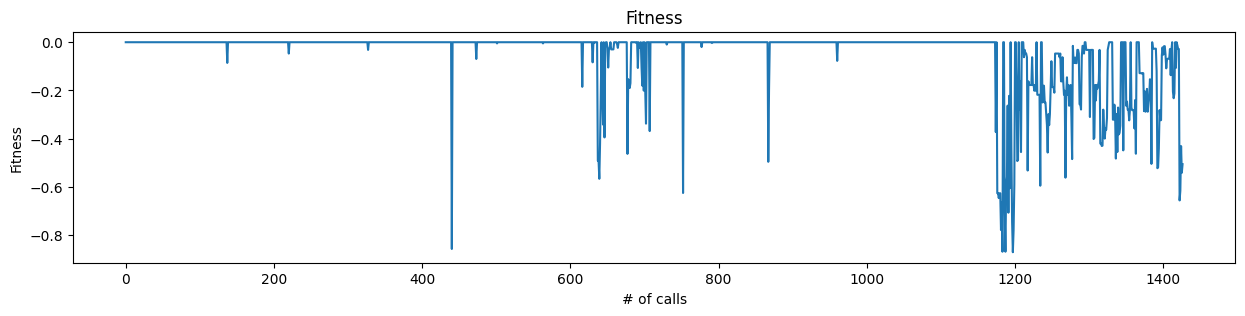

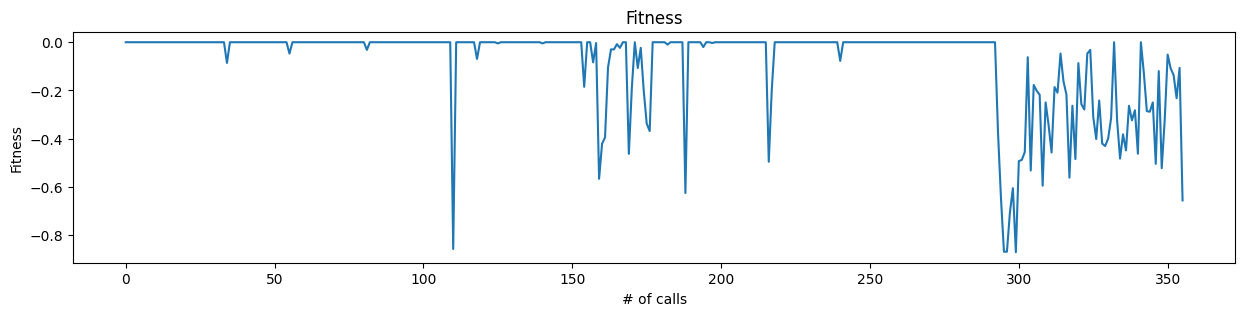

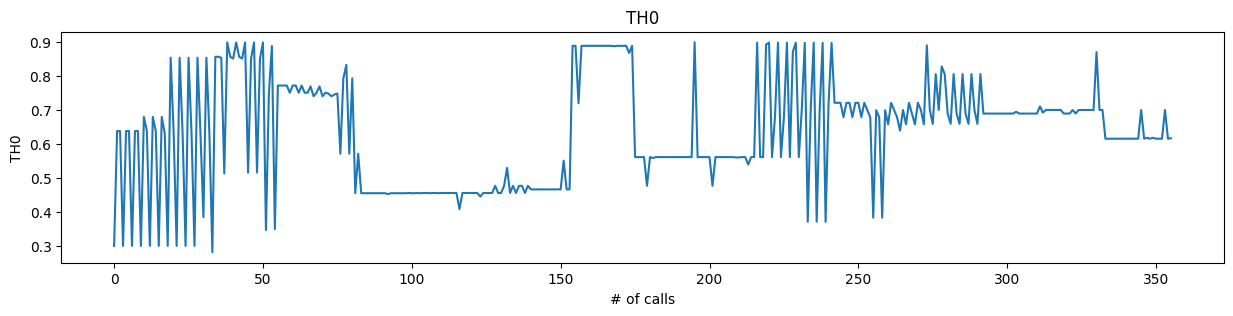

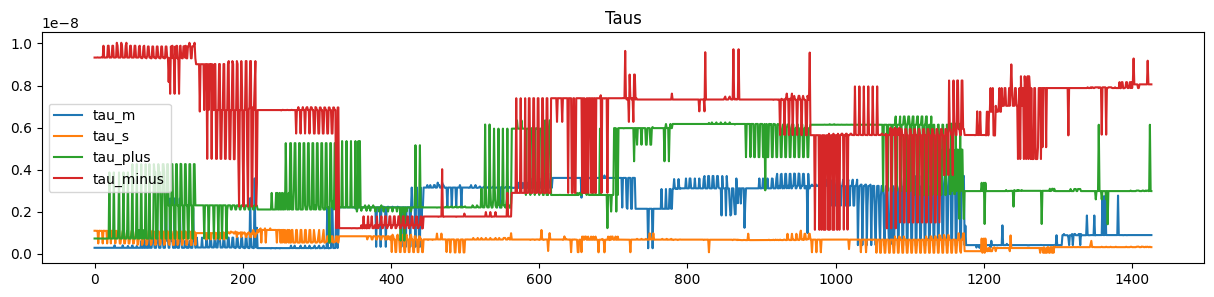

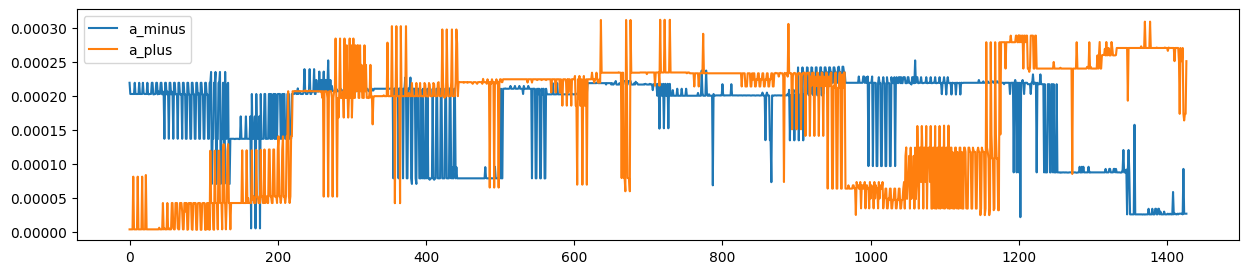

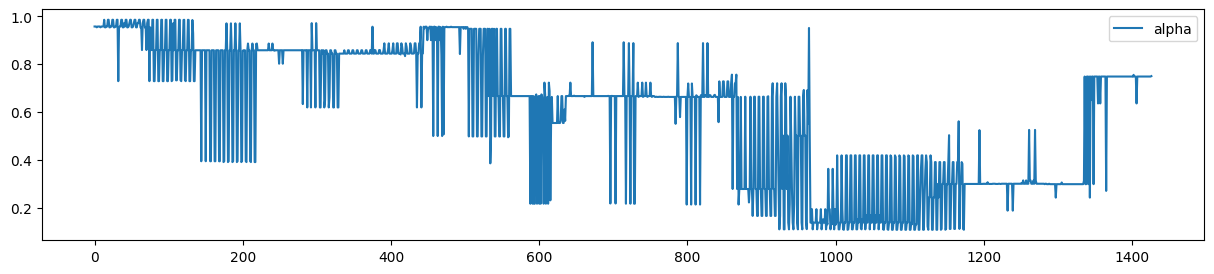

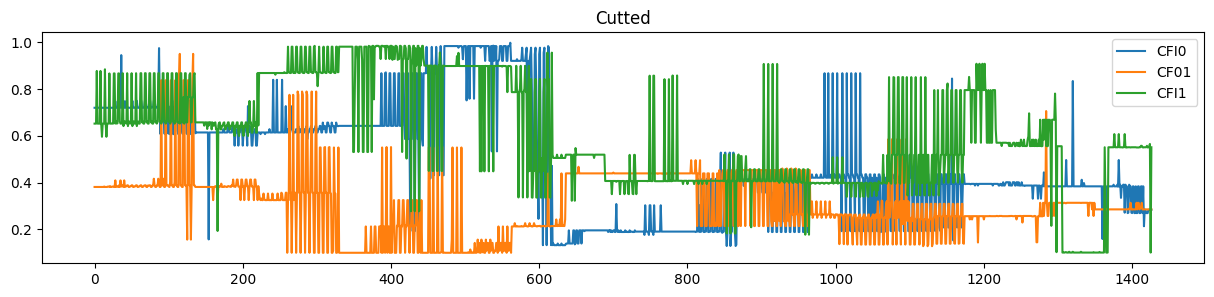

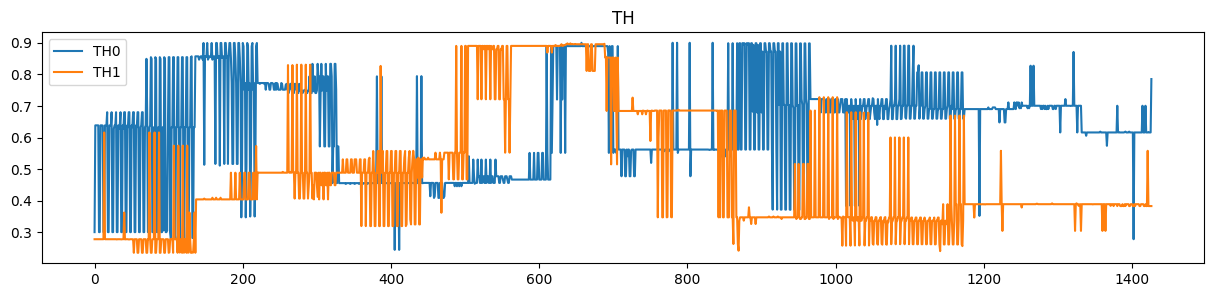

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#read the values.csv
df = pd.read_csv('values.csv')


#adjust the figure size
plt.figure(figsize=(15,3))
#plot the fitness
pop_fit = []
best_generat = []
best_param = []
j = 0 
for i in range(len(df['fitness'])):
    j = j + 1
    pop_fit.append(df['fitness'][i])

    if j == population_size:
        best_generat.append(np.min(pop_fit))
        index = np.argmin(pop_fit)
        best_param.append(df['TH0'][i - population_size + index +1])
        j = 0
        pop_fit = []


#adjust the figure size
plt.figure(figsize=(15,3))
#plot the fitness
plt.plot(df['fitness'])
plt.title('Fitness')
plt.xlabel('# of calls')
plt.ylabel('Fitness')
plt.show()


#adjust the figure size
plt.figure(figsize=(15,3))
#plot the fitness
plt.plot(best_generat)
plt.title('Fitness')
plt.xlabel('# of calls')
plt.ylabel('Fitness')
plt.show()

plt.figure(figsize=(15,3))
plt.plot(best_param)
plt.title('TH0')
plt.xlabel('# of calls')
plt.ylabel('TH0')
plt.show()


#plot the taus
plt.figure(figsize=(15,3))
plt.plot(df['tau_m'], label='tau_m')
plt.plot(df['tau_s'], label='tau_s')
plt.plot(df['tau_plus'], label='tau_plus')
plt.plot(df['tau_minus'], label='tau_minus')
plt.title('Taus')
plt.legend()
plt.show()

#plt the a 
plt.figure(figsize=(15,3))
plt.plot(df['a_minus'], label='a_minus')
plt.plot(df['a_plus'], label='a_plus')
plt.legend()
plt.show()


plt.figure(figsize=(15,3))
plt.plot(df['alpha'], label='alpha')
plt.legend()
plt.show()

#plot the CFI
plt.figure(figsize=(15,3))
plt.plot(df['CFI0'], label='CFI0')
plt.plot(df['CF01'], label='CF01')
plt.plot(df['CFI1'], label='CFI1')
plt.title('Cutted')
plt.legend()
plt.show()

#plot the TH
plt.figure(figsize=(15,3))
plt.plot(df['TH0'], label='TH0')
plt.plot(df['TH1'], label='TH1')
plt.title('TH')
plt.legend()
plt.show()


Text(0.5, 0, '# of calls')

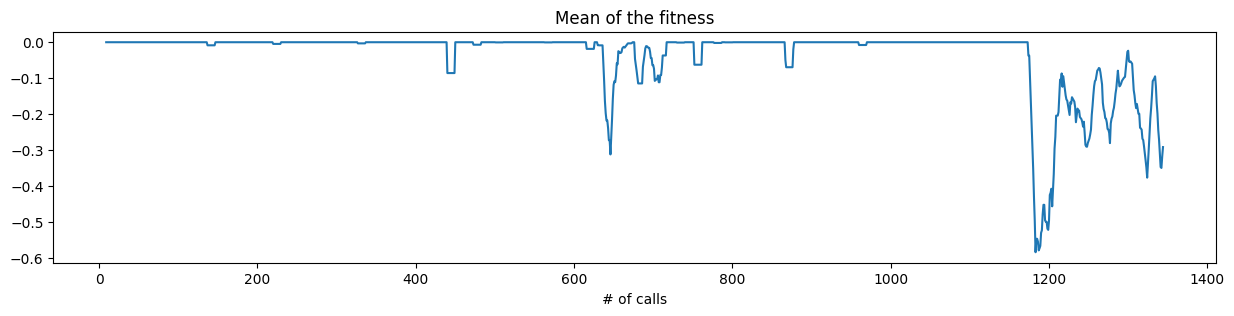

In [ ]:
#plot the mean of the fitness
plt.figure(figsize=(15,3))
plt.plot(df['fitness'].rolling(window=10).mean())
plt.title('Mean of the fitness')    
plt.xlabel('# of calls')

In [ ]:
#find the best fitness and the corresponding paraemters
best_fitness = df['fitness'].min()
best_parameters = df[df['fitness'] == best_fitness]
best_parameters


,tau_m,tau_s,tau_plus,tau_minus,a_minus,a_plus,CFI0,CF01,CFI1,alpha,TH0,TH1,fitness
1197,4.149560e-10,7.256598e-10,3.376012e-09,5.647413e-09,0.000088,0.000289,0.394721,0.256598,0.795894,0.298827,0.690176,0.388636,-0.87026


In [ ]:
!../SNNT13.out --N_ev 10000 --tau_m 2.420088e-09 --tau_s 4.716520e-10 --tau_plus 5.235836e-09 --tau_minus 8.783522e-09 --a_plus 0.000149 --a_minus 0.000019 --CFI0 0.633138	 --CF01 0.965689 --CFI1 0.648094 --alpha 0.94 --TH0 0.6 --TH1 0.83



                                 ------------------------------------

                                    S   N   N      T r a c k i n g

                                 ------------------------------------




         ------------------------------------------------------------------------------------    
         Unsupervised search for tracks in 8-layer strip detector with spiking neural network    
                                                                             T.Dorigo, 3/2023    
         ------------------------------------------------------------------------------------    

         Run parameters: 
         -----------------------------------
                       L0 neurons: 6
                       L1 neurons: 6
            Connected L0-L1 frac.: 0.965689
            Connected IN-L0 frac.: 0.633138
            Connected IN-L1 frac.: 0.648094
                    Track classes: 6
                     Total events: 10000
               Optimization loops: 1
